# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [16]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.cluster import AgglomerativeClustering

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
from wordcloud import WordCloud

from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min # for interpretability

### Reading the dataset

In [18]:
#loading train and test and validation dataset

file=open("x_train.pkl","rb")
x_train=pickle.load(file) # loading 'train' dataset

file=open("x_cv.pkl",'rb')
x_cv=pickle.load(file) # loading 'validation' dataset

file=open("x_test.pkl",'rb')
x_test=pickle.load(file) # loading 'test' dataset

file=open("y_train.pkl","rb")
y_train=pickle.load(file) # loading 'train' dataset

file=open("y_cv.pkl",'rb')
y_cv=pickle.load(file) # loading 'validation' dataset

file=open("y_test.pkl",'rb')
y_test=pickle.load(file) # loading 'test' dataset

#loading train_bow and test _bow
file=open('x_train_bow.pkl','rb')
x_train_bow=pickle.load(file)

file=open('x_test_bow.pkl','rb')
x_test_bow=pickle.load(file)

file=open('x_cv_bow.pkl','rb')
x_cv_bow=pickle.load(file)

#loading train_tf_idf and test_tf_idf
file=open('train_tf_idf.pkl','rb')
train_tf_idf=pickle.load(file)

file=open('cv_tf_idf.pkl','rb')
cv_tf_idf=pickle.load(file)

file=open('test_tf_idf.pkl','rb')
test_tf_idf=pickle.load(file)

#loading train_w2v and test_w2v
file=open('train_w2v.pkl','rb')
train_w2v=pickle.load(file)

file=open('cv_w2v.pkl','rb')
cv_w2v=pickle.load(file)

file=open('test_w2v.pkl','rb')
test_w2v=pickle.load(file)

#loading train_tf_idf_w2v and test_tf_idf_w2v
file=open('train_tf_idf_w2v.pkl','rb')
train_tf_idf_w2v=pickle.load(file)

file=open('cv_tf_idf_w2v.pkl','rb')
cv_tf_idf_w2v=pickle.load(file)

file=open('test_tf_idf_w2v.pkl','rb')
test_tf_idf_w2v=pickle.load(file)

# [5] Assignment 10: K-Means, Agglomerative & DBSCAN Clustering

<ol>
    <li><strong>Apply K-means Clustering on these feature sets:</strong>
        <ul>
    <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Find the best ‘k’ using the elbow-knee method (plot k vs inertia_)</li>
    <li>Once after you find the k clusters, plot the word cloud per each cluster so that at a single
go we can analyze the words in a cluster.</li>          
        </ul>
    </li>
    <br>
    <li><strong>Apply Agglomerative Clustering on these feature sets:</strong>
        <ul>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Apply agglomerative algorithm and try a different number of clusters like 2,5 etc.</li>
    <li>Same as that of K-means, plot word clouds for each cluster and summarize in your own words what that cluster is representing.</li>
            <li>You can take around 5000 reviews or so(as this is very computationally expensive one)</li>
        </ul>
    </li>
    <br>
    <br>
    <li><strong>Apply DBSCAN Clustering on these feature sets:</strong>
        <ul>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Find the best ‘Eps’ using the <a href='https://stackoverflow.com/questions/12893492/choosing-eps-and-minpts-for-dbscan-r/48558030#48558030'>elbow-knee method.</a></li>
    <li>Same as before, plot word clouds for each cluster and summarize in your own words what that cluster is representing.</li>
            <li>You can take around 5000 reviews for this as well.</li>
        </ul>
    </li>
</ol>

## [5.1] K-Means Clustering

### [5.1.1] Applying K-Means Clustering on BOW,<font color='red'> SET 1</font>

In [19]:
# removing all the reviews with no text
x_train=pd.DataFrame(x_train)
x_train=x_train[(x_train[0].apply(lambda x : len(x)))>0]

# BOW of x_train(reviews)
cv=CountVectorizer()
x_train_bow=cv.fit_transform(x_train[0])

In [24]:
# using silhouette score for choosing best K
from sklearn.metrics import silhouette_score
# Choosing right K using elbow method
ss=[]
inertia=[]
k=[2,4,5,6,8,10,15,20]

for i in k:
    km=KMeans(n_clusters=i,
                        init='k-means++',
                        n_init=10,
                        n_jobs=-2)
    km.fit(x_train_bow[:100000])
    inertia.append(round(km.inertia_,3))
    ss.append(silhouette_score(x_train_bow[:100000],km.predict(x_train_bow[:100000])))
    

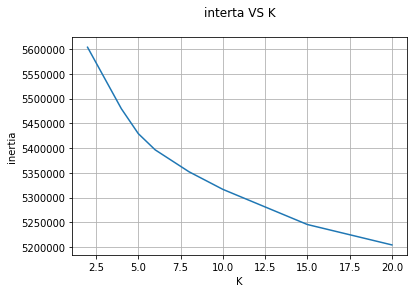

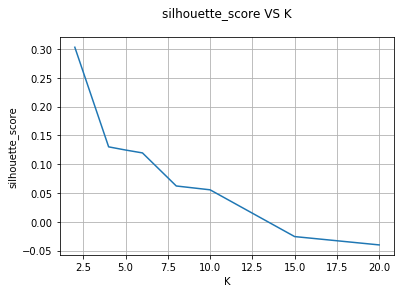

In [25]:
plt.plot(k,inertia)
plt.title("interta VS K\n")
plt.xlabel("K")
plt.ylabel("inertia")
plt.grid()
plt.show()

plt.plot(k,ss)
plt.title("silhouette_score VS K\n")
plt.xlabel("K")
plt.ylabel("silhouette_score")
plt.grid()
plt.show()

Elbow or knee point is at k=5

In [20]:
# clustering using right K
k=5
km=KMeans(n_clusters=k,
                    init='k-means++',
                    n_jobs=-2)
predict=km.fit_predict(x_train_bow[:100000])

In [21]:
(round(km.inertia_,3))

5429246.208

### [5.1.2] Wordclouds of clusters obtained after applying k-means on BOW<font color='red'> SET 1</font>

In [24]:
# giving datapoints which is closest to k centroid
closest, _ = pairwise_distances_argmin_min(km.cluster_centers_, x_train_bow[:100000])
closest

array([22793, 44716, 43704, 80540, 36626], dtype=int64)

### a. word cloud of k_cenroids

0    tea not tavalon tea chrysanthemum tea one clum...
Name: 22855, dtype: object

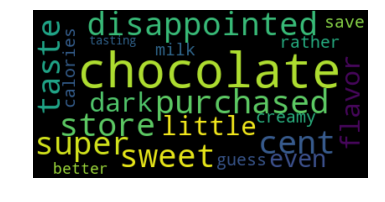

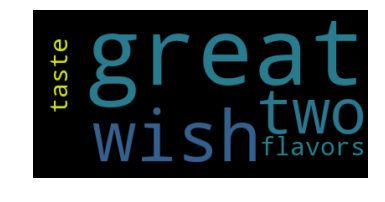

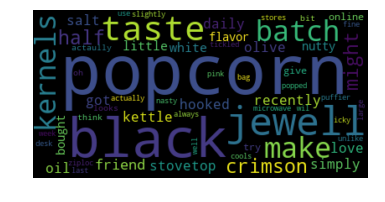

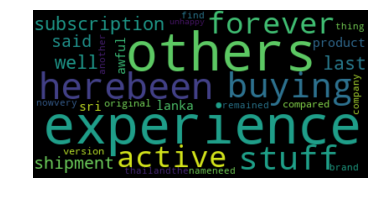

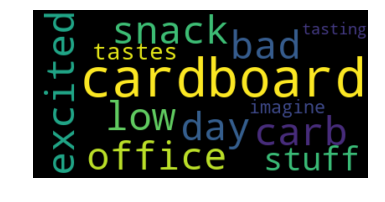

In [34]:
from wordcloud import WordCloud

text=[]
for i in closest:
    text=((x_train).loc[i][0])

    # Create and generate a word cloud image:
    wordcloud = WordCloud().generate(str(text))

    # Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

### b. word cloud of each cluster

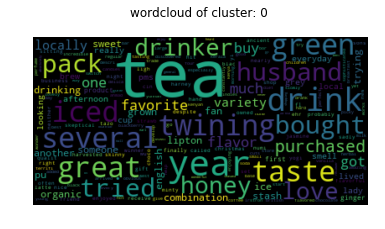

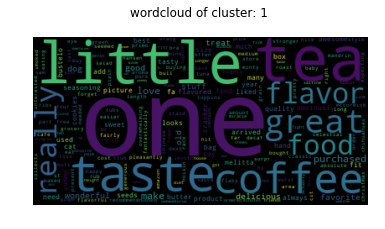

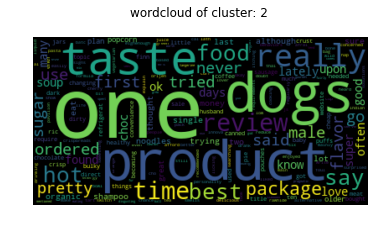

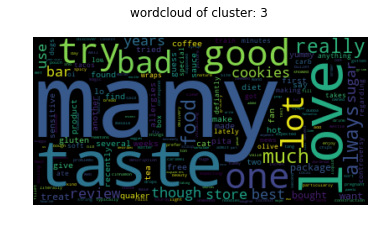

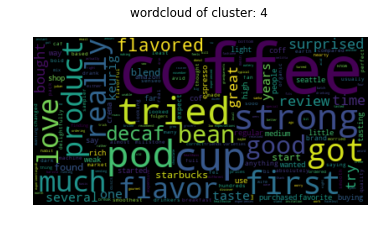

In [38]:
for i in np.unique(predict):
    text=(x_train).iloc[np.argwhere(predict==i).ravel()]

    # Create and generate a word cloud image:
    wordcloud = WordCloud().generate(str(text))

    # Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"wordcloud of cluster: {i} \n")
    plt.axis("off")
    plt.show()

### [5.1.3] Applying K-Means Clustering on TFIDF,<font color='red'> SET 2</font>

In [3]:
# removing all the reviews with no text
x_train=pd.DataFrame(x_train)
x_train=x_train[(x_train[0].apply(lambda x : len(x)))>0]

# BOW of x_train(reviews)
tf=TfidfVectorizer()
train_tfidf=tf.fit_transform(x_train[0][:100000])

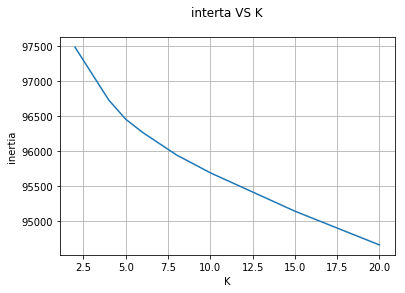

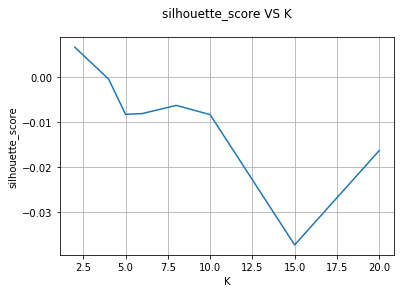

In [4]:
# using silhouette score
from sklearn.metrics import silhouette_score
# Choosing right K using elbow method
ss=[]
inertia=[]
k=[2,4,5,6,8,10,15,20]

for i in k:
    km=KMeans(n_clusters=i,
                        init='k-means++',
                        n_init=10,
                        n_jobs=-2)
    km.fit(train_tfidf[:100000])
    inertia.append(round(km.inertia_,3))
    ss.append(silhouette_score(train_tf_idf[:100000],km.predict(train_tfidf[:100000])))
    
#ploting
plt.plot(k,inertia)
plt.title("interta VS K\n")
plt.xlabel("K")
plt.ylabel("inertia")
plt.grid()
plt.show()

plt.plot(k,ss)
plt.title("silhouette_score VS K\n")
plt.xlabel("K")
plt.ylabel("silhouette_score")
plt.grid()
plt.show()

Elbow or knee point is at k=5

In [41]:
# clustering using right K
k=5
km=KMeans(n_clusters=k,
                    init='k-means++',
                    n_jobs=-2)
predict=km.fit_predict(train_tfidf[:100000])

In [42]:
(round(km.inertia_,3))

96457.159

### [5.1.4] Wordclouds of clusters obtained after applying k-means on TFIDF<font color='red'> SET 2</font>

In [43]:
# giving datapoints which is closest to k centroid
# Reason i am choosing consine distace because of high dimension which cause curse of dimentionality
closest, _ = pairwise_distances_argmin_min(km.cluster_centers_, train_tfidf[:100000],metric='cosine')
closest

array([83198, 69666, 99692, 36626, 59436], dtype=int64)

### a. word cloud of k_cenroids

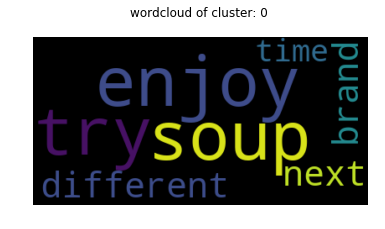

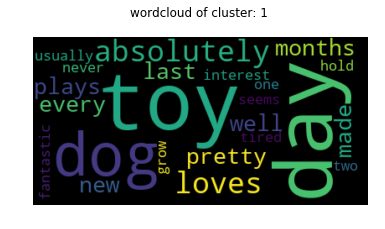

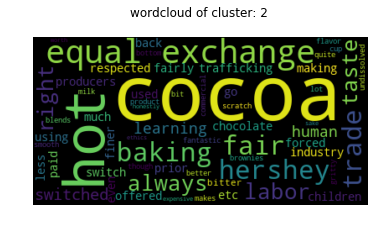

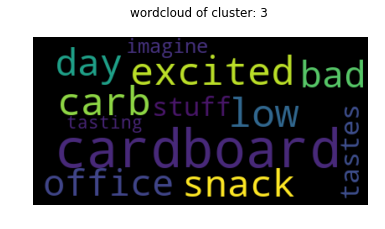

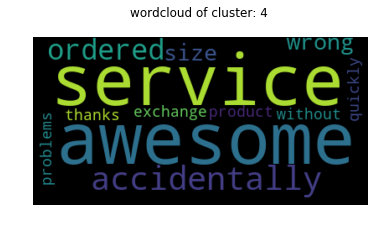

In [53]:
# word cloud of k_cenroids
from wordcloud import WordCloud

for idx,closest_pt in enumerate(closest):
    text=(x_train[closest_pt])

    # Create and generate a word cloud image:
    wordcloud = WordCloud().generate(str(text))

    # Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"wordcloud of cluster: {idx} \n")
    plt.axis("off")
    plt.show()

### b. word cloud of each cluster

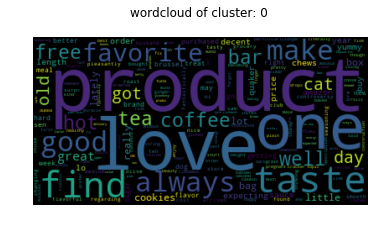

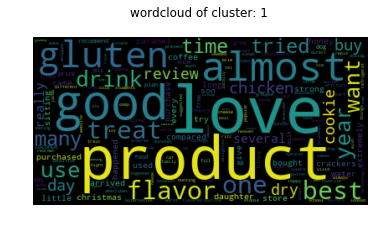

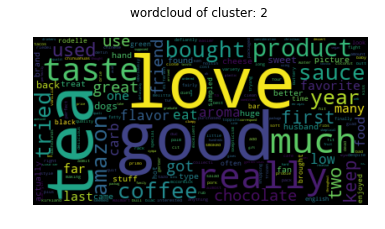

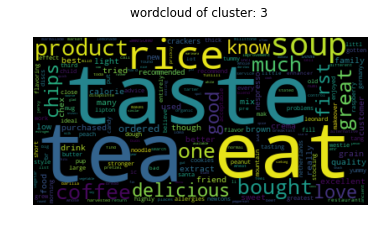

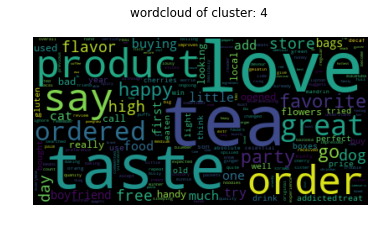

In [52]:
# word cloud of each cluster
for i in np.unique(predict):
    text=pd.Series(x_train).iloc[np.argwhere(predict==i).ravel()]

    # Create and generate a word cloud image:
    wordcloud = WordCloud().generate(str(text))

    # Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"wordcloud of cluster: {i} \n")
    plt.axis("off")
    plt.show()

### [5.1.5] Applying K-Means Clustering on AVG W2V,<font color='red'> SET 3</font>

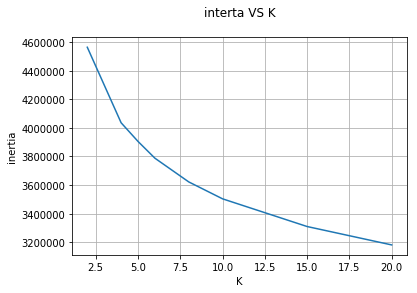

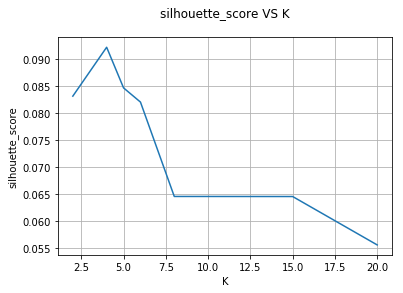

In [59]:
# using silhouette score
from sklearn.metrics import silhouette_score
# Choosing right K using elbow method
ss=[]
inertia=[]
k=[2,4,5,6,8,10,15,20]

for i in k:
    km=KMeans(n_clusters=i,
                        init='k-means++',
                        n_init=10,
                        n_jobs=-2)
    km.fit(train_w2v[:100000])
    inertia.append(round(km.inertia_,3))
    ss.append(silhouette_score(train_w2v[:100000],km.predict(train_w2v[:100000])))

# ploting
plt.plot(k,inertia)
plt.title("interta VS K\n")
plt.xlabel("K")
plt.ylabel("inertia")
plt.grid()
plt.show()

plt.plot(k,ss)
plt.title("silhouette_score VS K\n")
plt.xlabel("K")
plt.ylabel("silhouette_score")
plt.grid()
plt.show()

Elbow or knee point is at k=4

In [77]:
# clustering using optimal K
k=4
km=KMeans(n_clusters=k,
                    init='k-means++',
                    n_jobs=-2)
predict=km.fit_predict(train_w2v[:100000])

(round(km.inertia_,3))

4035882.246

### [5.1.6] Wordclouds of clusters obtained after applying k-means on AVG W2V<font color='red'> SET 3</font>

In [95]:
# giving datapoints which is closest to k centroid
closest, _ = pairwise_distances_argmin_min(km.cluster_centers_, train_w2v)
closest

array([147132, 161268,  73895, 200115], dtype=int64)

### a. word cloud of k_cenroids

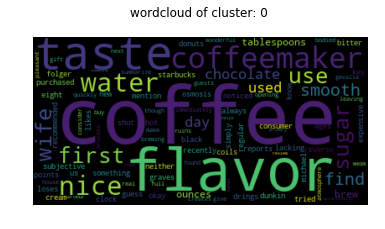

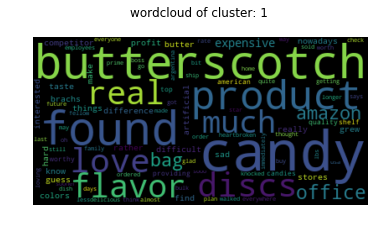

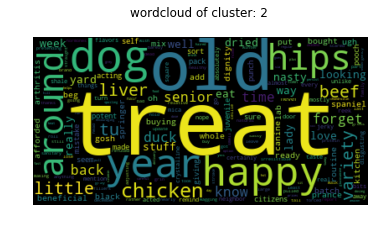

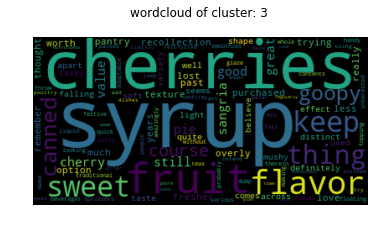

In [99]:
# word cloud of k_cenroids
from wordcloud import WordCloud

for idx,closest_pt in enumerate(closest):
    text=(x_train[closest_pt])

    # Create and generate a word cloud image:
    wordcloud = WordCloud().generate(str(text))

    # Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"wordcloud of cluster: {idx} \n")
    plt.axis("off")
    plt.show()

### b. word cloud of each cluster

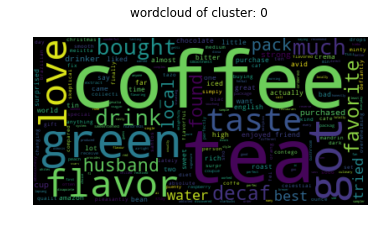

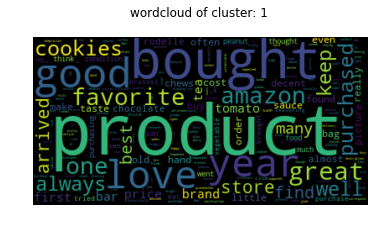

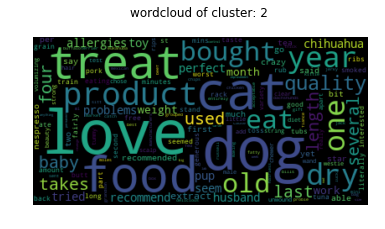

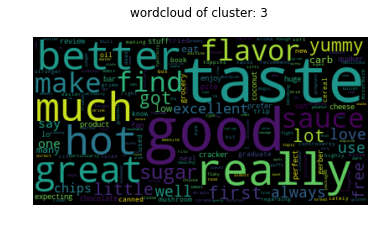

In [101]:
# word cloud of each cluster
for i in np.unique(predict):
    text=pd.Series(x_train).iloc[np.argwhere(predict==i).ravel()]

    # Create and generate a word cloud image:
    wordcloud = WordCloud().generate(str(text))

    # Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"wordcloud of cluster: {i} \n")
    plt.axis("off")
    plt.show()

### [5.1.7] Applying K-Means Clustering on TFIDF W2V,<font color='red'> SET 4</font>

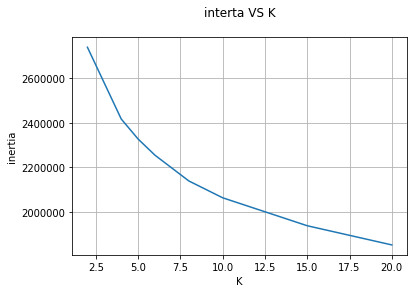

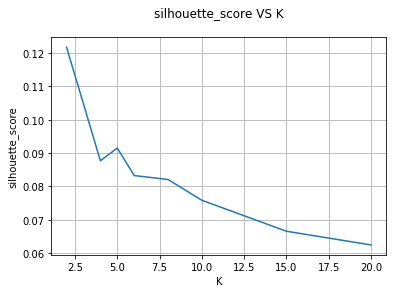

In [104]:
# using silhouette score
from sklearn.metrics import silhouette_score
# Choosing right K using elbow method
ss=[]
inertia=[]
k=[2,4,5,6,8,10,15,20]

for i in k:
    km=KMeans(n_clusters=i,
                        init='k-means++',
                        n_init=10,
                        n_jobs=-2)
    km.fit(train_tf_idf_w2v[:100000])
    inertia.append(round(km.inertia_,3))
    ss.append(silhouette_score(train_tf_idf_w2v[:100000],km.predict(train_tf_idf_w2v[:100000])))
    

plt.plot(k,inertia)
plt.title("interta VS K\n")
plt.xlabel("K")
plt.ylabel("inertia")
plt.grid()
plt.show()

plt.plot(k,ss)
plt.title("silhouette_score VS K\n")
plt.xlabel("K")
plt.ylabel("silhouette_score")
plt.grid()
plt.show()

Elbow or knee point is at k=4

In [105]:
# clustering using right K
k=4
km=KMeans(n_clusters=k,
                    init='k-means++',
                    n_jobs=-2)
km.fit(train_tf_idf_w2v[:100000])

(round(km.inertia_,3))

2417368.286

### [5.1.8] Wordclouds of clusters obtained after applying k-means on TFIDF W2V<font color='red'> SET 4</font>

In [106]:
# giving datapoints which is closest to k centroid
closest, _ = pairwise_distances_argmin_min(km.cluster_centers_, train_tf_idf_w2v[:100000])
closest

array([59666, 19999, 44717,  8096], dtype=int64)

### a. word cloud of k_cenroids

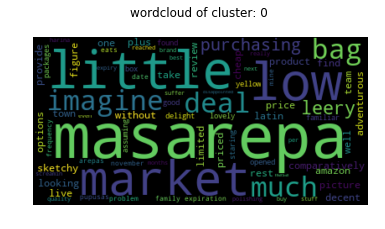

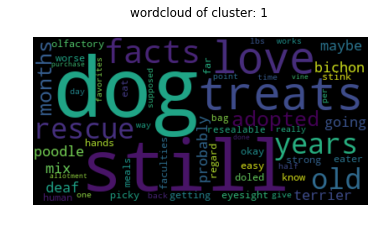

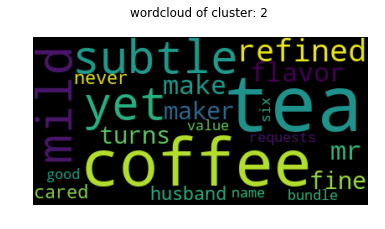

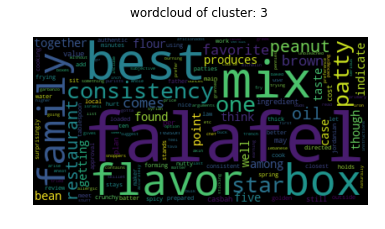

In [107]:
# word cloud of k_cenroids
from wordcloud import WordCloud

for idx,closest_pt in enumerate(closest):
    text=(x_train[closest_pt])

    # Create and generate a word cloud image:
    wordcloud = WordCloud().generate(str(text))

    # Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"wordcloud of cluster: {idx} \n")
    plt.axis("off")
    plt.show()

### b. word cloud of each cluster

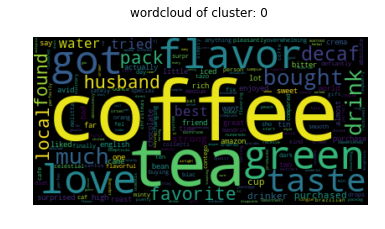

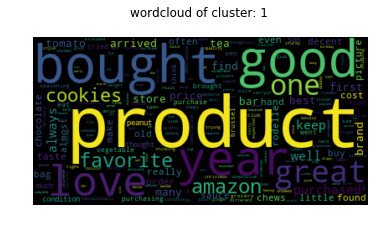

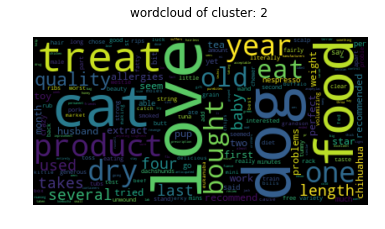

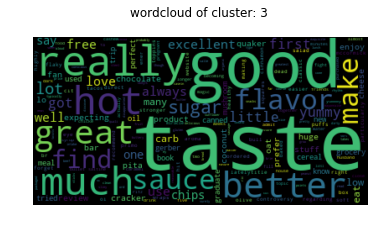

In [108]:
# word cloud of each cluster
for i in np.unique(predict):
    text=pd.Series(x_train).iloc[np.argwhere(predict==i).ravel()]

    # Create and generate a word cloud image:
    wordcloud = WordCloud().generate(str(text))

    # Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"wordcloud of cluster: {i} \n")
    plt.axis("off")
    plt.show()

## [5.2] Agglomerative Clustering

### [5.2.1] Applying Agglomerative Clustering on AVG W2V,<font color='red'> SET 3</font>

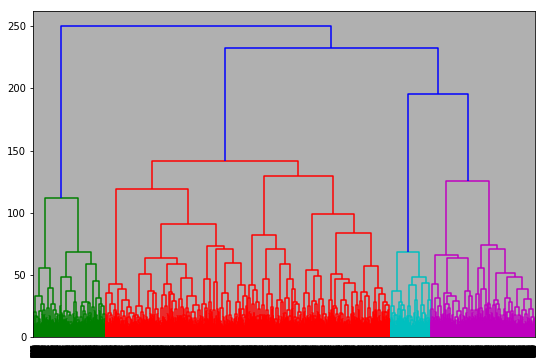

In [99]:
from scipy.cluster.hierarchy import dendrogram, linkage

Z = linkage(train_w2v[:10000],'ward')

plt.figure(figsize=(9,6))
dendrogram(Z,)
plt.grid()
plt.show()

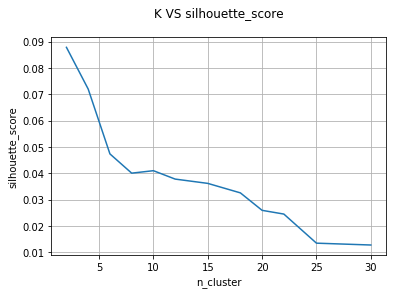

In [109]:
# using silhouette score
from sklearn.metrics import silhouette_score
# Choosing right K using elbow method

k=[2,4,6,8,10,12,15,18,20,22,25,30]
ss=[]
for i in k:
    agg_clust=AgglomerativeClustering(n_clusters=i,linkage='ward')
    p=agg_clust.fit_predict(train_w2v[:10000])
    ss.append(silhouette_score(train_w2v[:10000],p))

plt.plot(k,ss)
plt.grid()
plt.title("K VS silhouette_score\n ")
plt.xlabel("n_cluster")
plt.ylabel("silhouette_score")
plt.show()

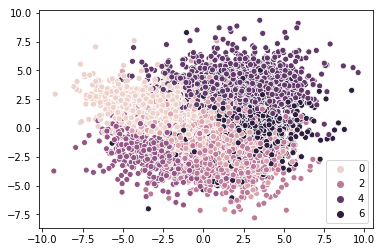

In [110]:
# optimal k=6
agg_clust=AgglomerativeClustering(n_clusters=6)
predict=agg_clust.fit_predict(train_w2v[:10000])
    
# visualising clusters    
from sklearn.decomposition import TruncatedSVD
svd=TruncatedSVD(n_components=2)
svd_transform=svd.fit_transform(train_w2v[:10000])
sns.scatterplot(svd_transform[:,0],svd_transform[:,1],hue=predict)
plt.show()

### [5.2.2] Wordclouds of clusters obtained after applying Agglomerative Clustering on AVG W2V<font color='red'> SET 3</font>

### a. word cloud of each cluster

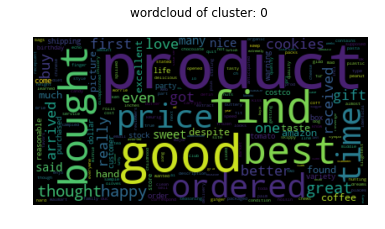

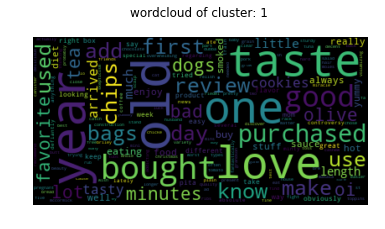

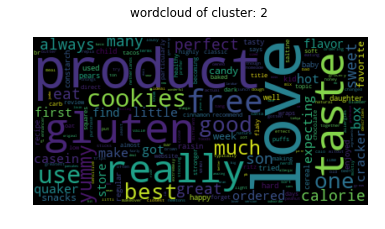

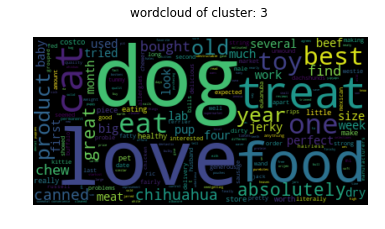

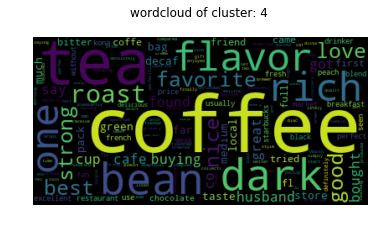

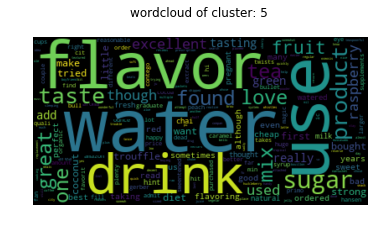

In [111]:
# word cloud of each cluster
for i in np.unique(predict):
    text=pd.Series(x_train).iloc[np.argwhere(predict==i).ravel()]

    # Create and generate a word cloud image:
    wordcloud = WordCloud().generate(str(text))

    # Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"wordcloud of cluster: {i} \n")
    plt.axis("off")
    plt.show()

### [5.2.3] Applying Agglomerative Clustering on TFIDF W2V,<font color='red'> SET 4</font>

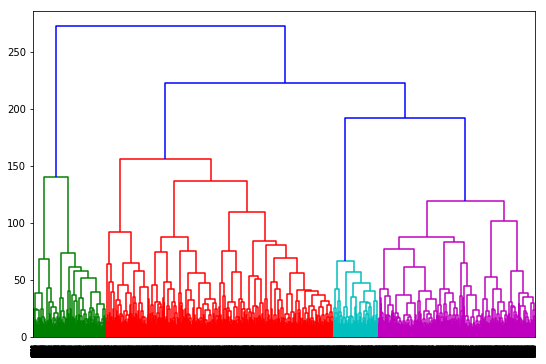

In [100]:
from scipy.cluster.hierarchy import dendrogram, linkage

Z = linkage(train_tf_idf_w2v[:10000],'ward')

plt.figure(figsize=(9,6))
dendrogram(Z,)
plt.show()

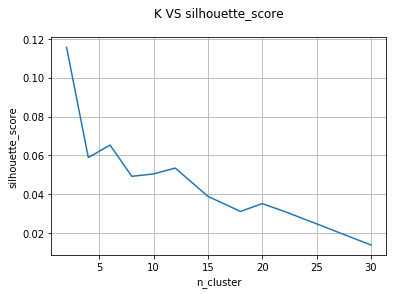

In [112]:
# using silhouette score
from sklearn.metrics import silhouette_score
# Choosing right K using elbow method

k=[2,4,6,8,10,12,15,18,20,22,25,30]
ss=[]
for i in k:
    agg_clust=AgglomerativeClustering(n_clusters=i,linkage='ward')
    p=agg_clust.fit_predict(train_tf_idf_w2v[:10000])
    ss.append(silhouette_score(train_tf_idf_w2v[:10000],p))

plt.plot(k,ss)
plt.grid()
plt.title("K VS silhouette_score\n ")
plt.xlabel("n_cluster")
plt.ylabel("silhouette_score")
plt.show()

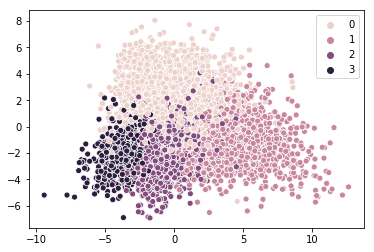

In [113]:
# optimal k=4
agg_clust=AgglomerativeClustering(n_clusters=4)
predict=agg_clust.fit_predict(train_tf_idf_w2v[:10000])
    
# visualising clusters    
from sklearn.decomposition import TruncatedSVD
svd=TruncatedSVD(n_components=2)
svd_transform=svd.fit_transform(train_tf_idf_w2v[:10000])
sns.scatterplot(svd_transform[:,0],svd_transform[:,1],hue=predict)
plt.show()

### [5.2.4] Wordclouds of clusters obtained after applying Agglomerative Clustering on TFIDF W2V<font color='red'> SET 4</font>

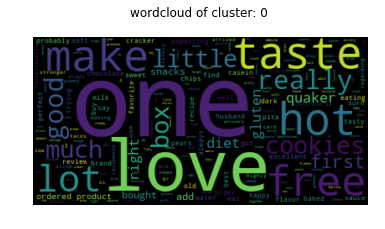

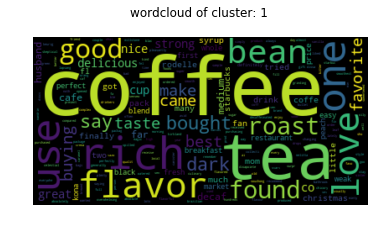

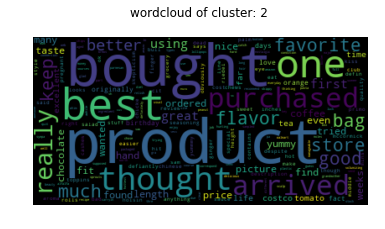

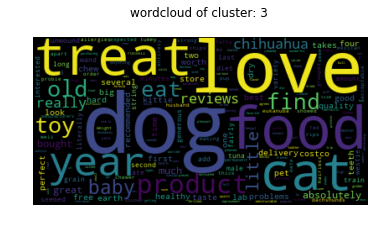

In [114]:
# word cloud of each cluster
for i in np.unique(predict):
    text=pd.Series(x_train).iloc[np.argwhere(predict==i).ravel()]

    # Create and generate a word cloud image:
    wordcloud = WordCloud().generate(str(text))

    # Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"wordcloud of cluster: {i} \n")
    plt.axis("off")
    plt.show()

## [5.3] DBSCAN Clustering

### [5.3.1] Applying DBSCAN on AVG W2V,<font color='red'> SET 3</font>

####  choosing correct epsilon and min_pts using elbow method

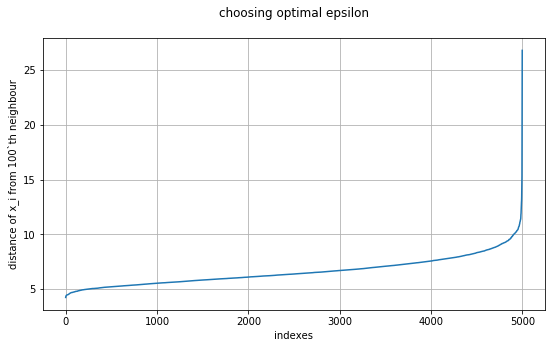

In [104]:
from sklearn.neighbors import NearestNeighbors

min_pts = train_w2v.shape[1]*2  # optimal number of min_pts

nn=NearestNeighbors(n_neighbors=min_pts,n_jobs=-2)
nn.fit(train_w2v[:5000])
neighours=nn.kneighbors(X=train_w2v[:5000], n_neighbors=min_pts, return_distance=True)

# choosing correct epsilon and min_pts using 
d_i=[]
for i in (range(0,len(train_w2v[:5000]))):
    d_i.append(neighours[0][i][99])
d_i.sort()

plt.figure(figsize=(9,5))
plt.title("choosing optimal epsilon\n")
plt.xlabel("indexes")
plt.ylabel("distance of x_i from 100`th neighbour")
plt.plot(range(0,len(d_i)),d_i)
plt.grid()
plt.show()

Optimal hyperparameter:

min_pts=100

epsilon=10

In [111]:
from sklearn.cluster import DBSCAN

optimum_epsilon=10
db_scan=DBSCAN(eps=optimum_epsilon,
    min_samples=min_pts,
    metric='euclidean',
    n_jobs=-2)
predict=db_scan.fit_predict(train_w2v[:10000])

### [5.3.2] Wordclouds of clusters obtained after applying DBSCAN on AVG W2V<font color='red'> SET 3</font>

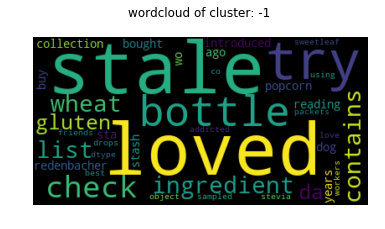

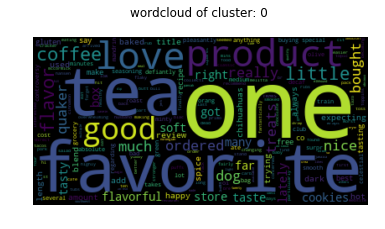

In [113]:
for i in np.unique(predict):
    text=pd.Series(x_train).iloc[np.argwhere(predict==i).ravel()]

    # Create and generate a word cloud image:
    wordcloud = WordCloud().generate(str(text))

    # Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"wordcloud of cluster: {i} \n")
    plt.axis("off")
    plt.show()

### [5.3.3] Applying DBSCAN on TFIDF W2V,<font color='red'> SET 4</font>

####  choosing correct epsilon and min_pts using elbow method

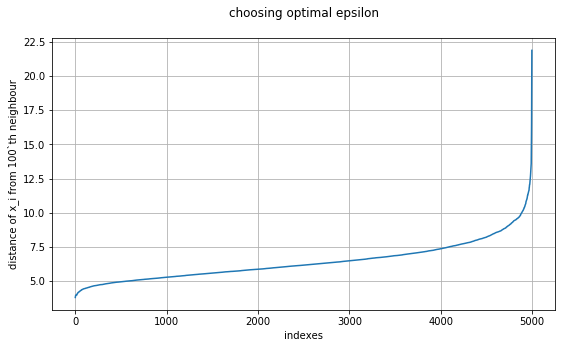

In [115]:
from sklearn.neighbors import NearestNeighbors

min_pts = train_tf_idf_w2v.shape[1]*2  # optimal number of min_pts

nn=NearestNeighbors(n_neighbors=min_pts,n_jobs=-2)
nn.fit(train_tf_idf_w2v[:5000])
neighours=nn.kneighbors(X=train_tf_idf_w2v[:5000], n_neighbors=min_pts, return_distance=True)

# choosing correct epsilon and min_pts 
d_i=[]
for i in (range(0,len(train_tf_idf_w2v[:5000]))):
    d_i.append(neighours[0][i][99])
d_i.sort()

plt.figure(figsize=(9,5))
plt.title("choosing optimal epsilon\n")
plt.xlabel("indexes")
plt.ylabel("distance of x_i from 100`th neighbour")
plt.plot(range(0,len(d_i)),d_i)
plt.grid()
plt.show()

Optimal hyperparameter:

min_pts=100

epsilon=10

In [116]:
from sklearn.cluster import DBSCAN

optimum_epsilon=10
db_scan=DBSCAN(eps=optimum_epsilon,
    min_samples=min_pts,
    metric='euclidean',
    n_jobs=-2)
predict=db_scan.fit_predict(train_tf_idf_w2v[:10000])

### [5.3.4] Wordclouds of clusters obtained after applying DBSCAN on TFIDF W2V<font color='red'> SET 4</font>

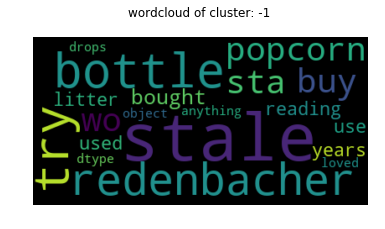

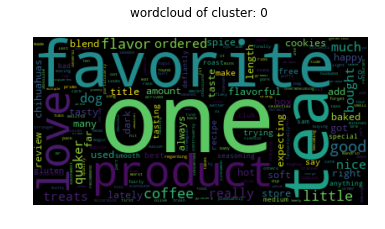

In [118]:
for i in np.unique(predict):
    text=pd.Series(x_train).iloc[np.argwhere(predict==i).ravel()]

    # Create and generate a word cloud image:
    wordcloud = WordCloud().generate(str(text))

    # Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"wordcloud of cluster: {i} \n")
    plt.axis("off")
    plt.show()

# [6] Conclusions

In [39]:
# Please compare all your models using Prettytable library
from prettytable import PrettyTable

print("*"*100)
print(" Model: K_mean")
x = PrettyTable()
x.field_names = ["featurization", "optimum_ckuster:K"]
x.add_row(["BOW", 5])
x.add_row(["TF-IDF", 5])
x.add_row([" W2V", 4])
x.add_row([" TF-IDF W2V", 4])
print(x)


print("\n","*"*100)
print(" Model: Hierarchical - Agglomerative")
print(" *note: Only 5k datapoints are used")
x = PrettyTable()
x.field_names = ["featurization", "optimum_ckuster:K"]
x.add_row([" W2V", 6])
x.add_row([" TF-IDF W2V", 4])
print(x)


print("\n","*"*100)
print(" Model: DBSCAN")
print(" *note: Only 5k datapoints are used")
x = PrettyTable()
x.field_names = ["featurization", "optimum_ckuster:K"]
x.add_row([" W2V", 2])
x.add_row([" TF-IDF W2V", 2])
print(x)

****************************************************************************************************
 Model: K_mean
+---------------+-------------------+
| featurization | optimum_ckuster:K |
+---------------+-------------------+
|      BOW      |         5         |
|     TF-IDF    |         5         |
|       W2V     |         4         |
|   TF-IDF W2V  |         4         |
+---------------+-------------------+

 ****************************************************************************************************
 Model: Hierarchical - Agglomerative
 *note: Only 5k datapoints are used
+---------------+-------------------+
| featurization | optimum_ckuster:K |
+---------------+-------------------+
|       W2V     |         6         |
|   TF-IDF W2V  |         4         |
+---------------+-------------------+

 ****************************************************************************************************
 Model: DBSCAN
 *note: Only 5k datapoints are used
+---------------+-----

1. Feature interpretation given by K_mean cluster is better than other in terms of interpretabilty.


2. K_mean and Agglomerative cluster seems to work better than DBSCAN (may be because of using very less datapoint)